## 1. 簡介：KD 指標與交易策略
---
* KD 指標計算 ：
    * `RSV = ((當日收盤價 - 近 N 日的最低價) / (近 N 日的最高價 - 近 N 日的最低價)) * 100`
    * `K 值 = 昨日 K 值 × (2/3) + 當日 RSV × (1/3)`
    * `D 值 = 昨日 D 值 × (2/3) + 當日 K 值 × (1/3)`

`Note本策略中 N = 10`

* 交易策略進出場規則 ：
    * **買入訊號 (Long Entry)**：當 K 值 ≤ 20 時，視為超賣，買入股票池中符合條件的股票，配置帳戶資金的 1%。
    * **賣出/出場訊號**：當 K 值 ≥ 80 時，視為超買，賣出持股以實現獲利 (本策略僅清倉，非放空)。

## 2. 環境設定與資料準備

1. 設定 TEJ API Key ： 將 YOUR_API_KEY 替換為您的 TEJ API Key。

In [ ]:
import os
tej_key = 'YOUR_API_KEY' # 請替換為您的 API Key
api_base = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE'] = api_base

2. 載入所需套件 ：

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.sources.TEJ_Api_Data import get_universe
from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.api import *
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage
from zipline.sources.TEJ_Api_Data import (get_Treasury_Return, get_Benchmark_Return)
import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False # 解決 Matplotlib 負號顯示問題

3. 設定回測期間與股票池 ： 本範例將回測 2012 年至 2022 年的台灣 50 指數成分股。

In [3]:
# 設定回測期間
start = '2012-01-01'
end = '2022-12-30'

# 抓取台灣50指數的股票 (IX0002) 與加權股價報酬指數 (IR0001)
StockList = get_universe(start, end, idx_id='IX0002')
StockList.append('IR0001')

os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start + ' ' + end

# 設定 Zipline 資料 bundle 名稱
bundle_name = 'tquant'

Currently used TEJ API key call quota 2/100000 (0.0%)
Currently used TEJ API key data quota 619/10000000 (0.01%)


In [4]:
# 用驚嘆號執行，它會帶著你在上面設定好的環境變數去跑
!zipline ingest -b tquant

[2026-01-28 05:59:44.735002] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]    
Currently used TEJ API key call quota 8/100000 (0.01%)
Currently used TEJ API key data quota 413079/10000000 (4.13%)
[2026-01-28 06:00:10.875011] INFO: zipline.data.bundles.core: Ingest tquant successfully.


## 3. 建構交易策略

策略參數設定

In [5]:
starting_portfolio = 1e6 # 初始資金 1,000,000 元
commission_pct = 0.0029 # 佣金費率 0.29%
slippage_volume_limit = 1.0 # 滑價交易量限制
slippage_impact = 0 # 滑價影響

建立 `Pipeline` 函式：計算 KD 指標

In [6]:
from zipline.pipeline.factors import FastStochasticOscillator

def make_pipeline():
    return Pipeline(
        columns = {
            "FastStochasticOscillator": FastStochasticOscillator(
                inputs = [TWEquityPricing.close, TWEquityPricing.low, TWEquityPricing.high],
                window_length = 10 # 計算 K 值所需的視窗長度，與上方 N=10 一致
            )
        }
    )

`initialize` 函式：設定回測環境

In [7]:
bundle = bundles.load('tquant')

def initialize(context):
    set_commission(PerDollar(cost=commission_pct)) # 設定佣金
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) # 設定滑價
    set_benchmark(symbol('IR0001')) # 設定基準指數為加權股價報酬指數
    attach_pipeline(make_pipeline(), 'mystrategy') # 導入 Pipeline

`handle_data` 函式：實作交易邏輯

In [8]:
def handle_data(context, data):
    # 取得每天 Pipeline 計算出的 K 值
    out_dir = pipeline_output('mystrategy')

    for asset in out_dir.index:
        k_value = out_dir.loc[asset, 'FastStochasticOscillator']
        position = context.portfolio.positions[asset].amount

        # 買入訊號：K 值 <= 20 且目前未持有該股票
        if position == 0 and k_value <= 20:
            order_target_percent(asset, 0.01) # 配置 1% 資金買入

        # 賣出訊號：K 值 >= 80 且目前持有該股票
        elif position > 0 and k_value >= 80:
            order_target_percent(asset, 0.0) # 清倉賣出

## 4. 執行回測

In [9]:
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar #日曆抓取工具

start_date = pd.Timestamp(start, tz='utc')
end_date = pd.Timestamp(end, tz='utc')

results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    capital_base=starting_portfolio,
    handle_data=handle_data,
    data_frequency='daily',
    bundle='tquant',
    trading_calendar=get_calendar('TEJ') #指定台灣日歷
)

## 5. 策略績效分析

Start date,2012-01-02
End date,2022-12-30
Total months,128
,Backtest
Annual return,-2.636%
Cumulative returns,-24.903%
Annual volatility,11.743%
Sharpe ratio,-0.17
Calmar ratio,-0.06
Stability,0.65
Max drawdown,-45.969%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.97,2015-01-23,2018-07-10,NaT,NaN
1,7.20,2012-03-14,2012-05-25,2015-01-05,700
2,0.92,2015-01-13,2015-01-16,2015-01-22,8
3,0.86,2012-02-29,2012-03-12,2012-03-14,12
4,0.39,2012-01-05,2012-01-16,2012-01-17,9


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Top 10 long positions of all time,max
sid,
2609,1.52%
2492,1.51%
2615,1.42%
3711,1.38%
2603,1.35%
6415,1.34%
2227,1.31%
2353,1.30%
2002,1.29%


Top 10 short positions of all time,max
sid,
2327,-81.82%
2201,-9.47%


Top 10 positions of all time,max
sid,
2327,81.82%
2201,9.47%
2609,1.52%
2492,1.51%
2615,1.42%
3711,1.38%
2603,1.35%
6415,1.34%
2227,1.31%


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

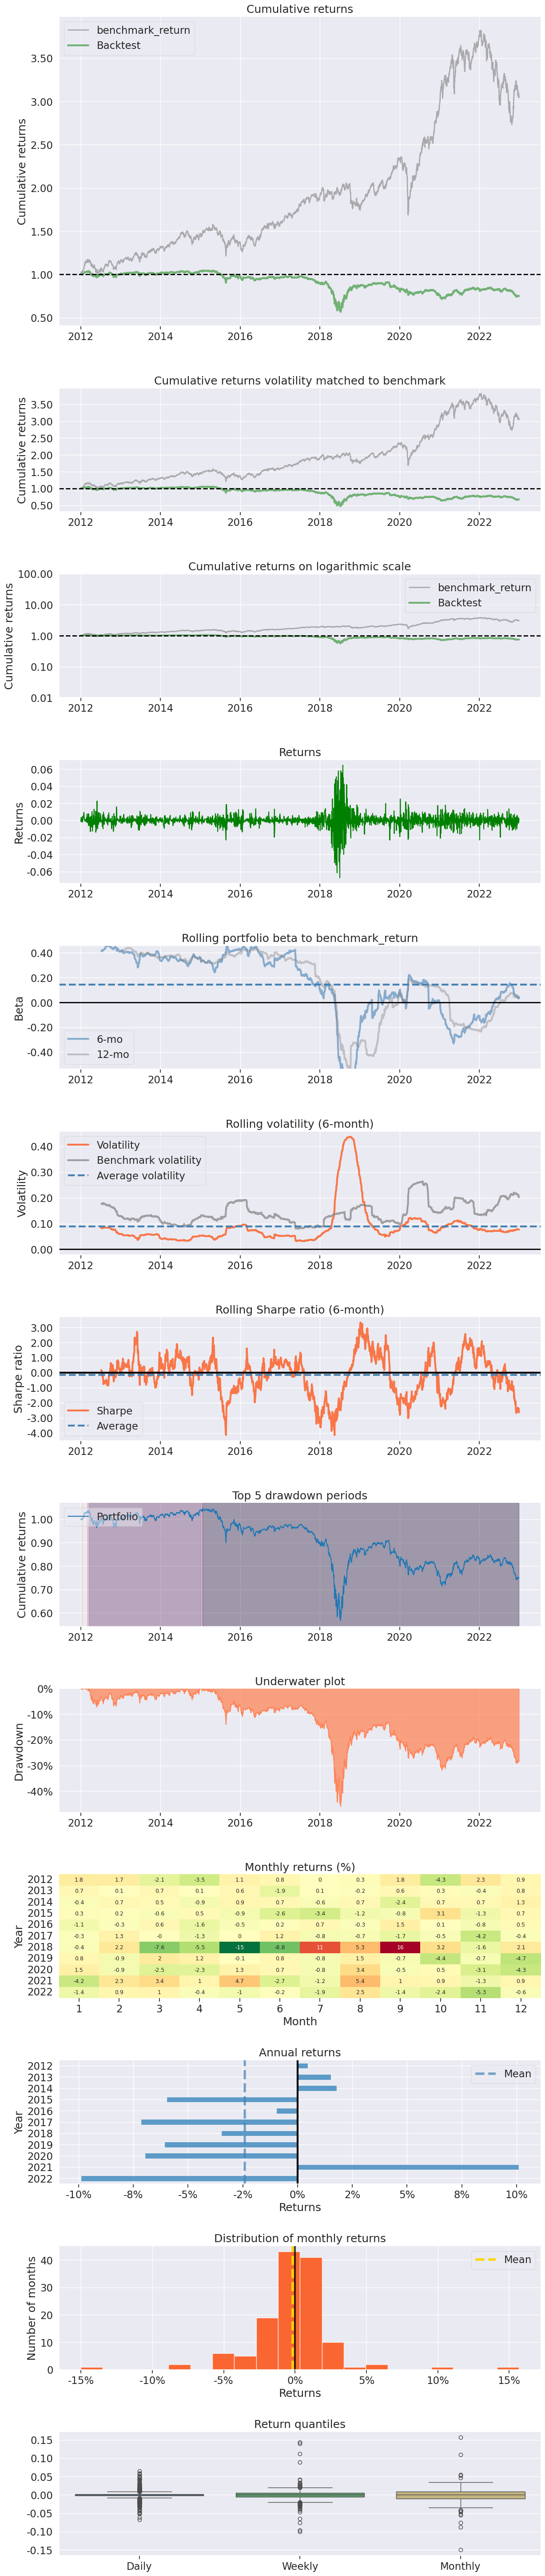

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

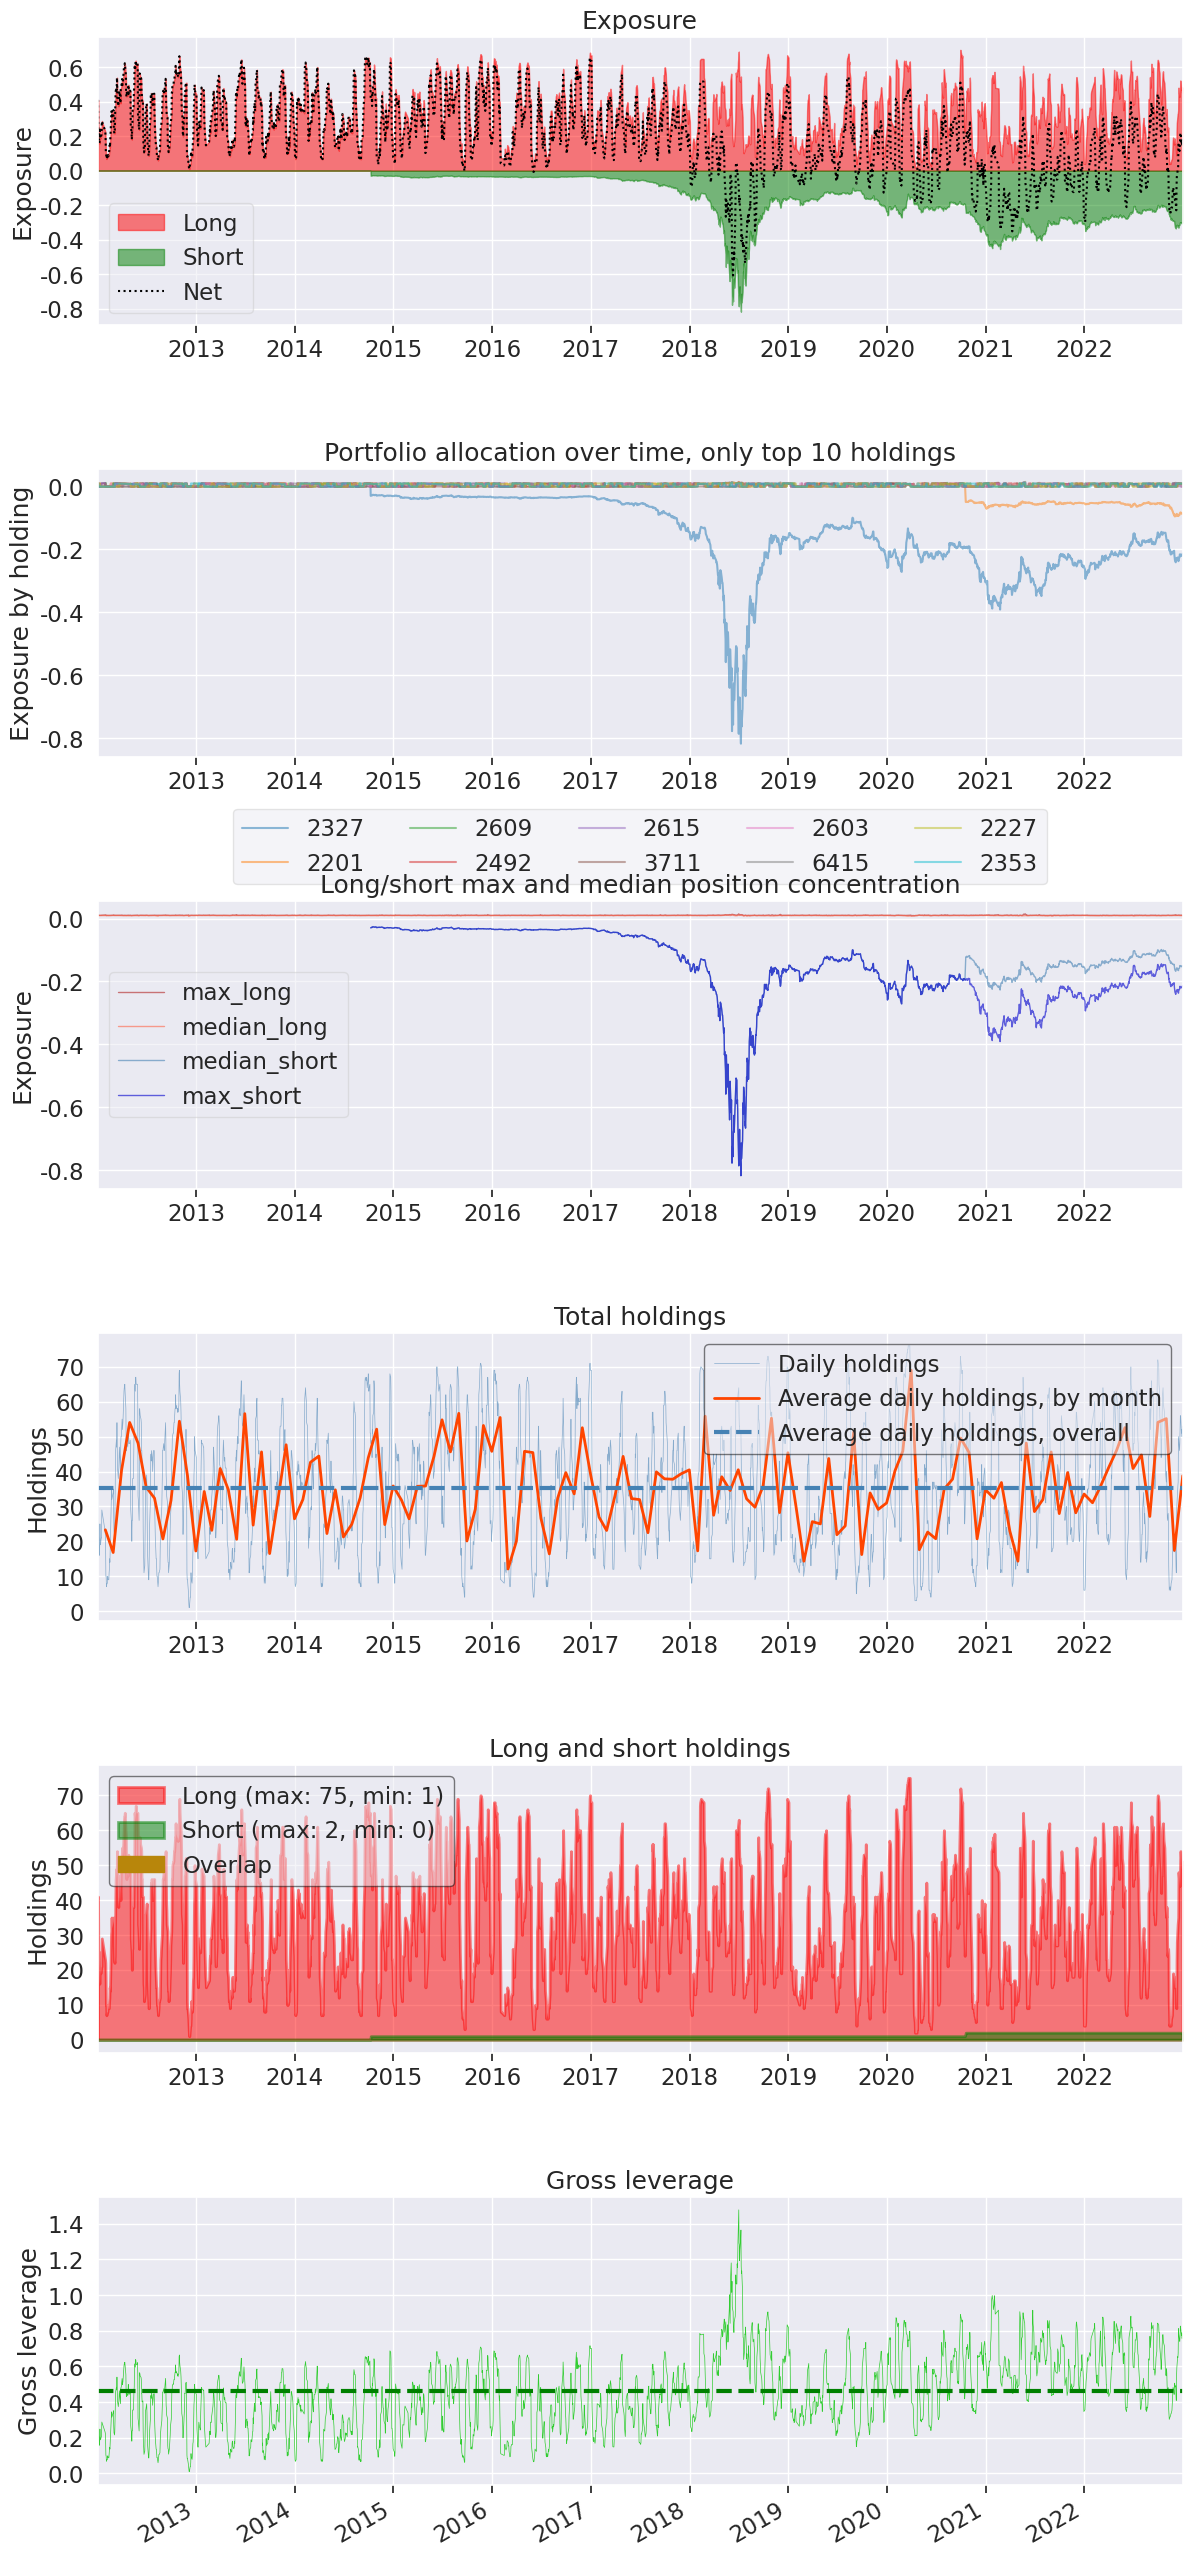

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

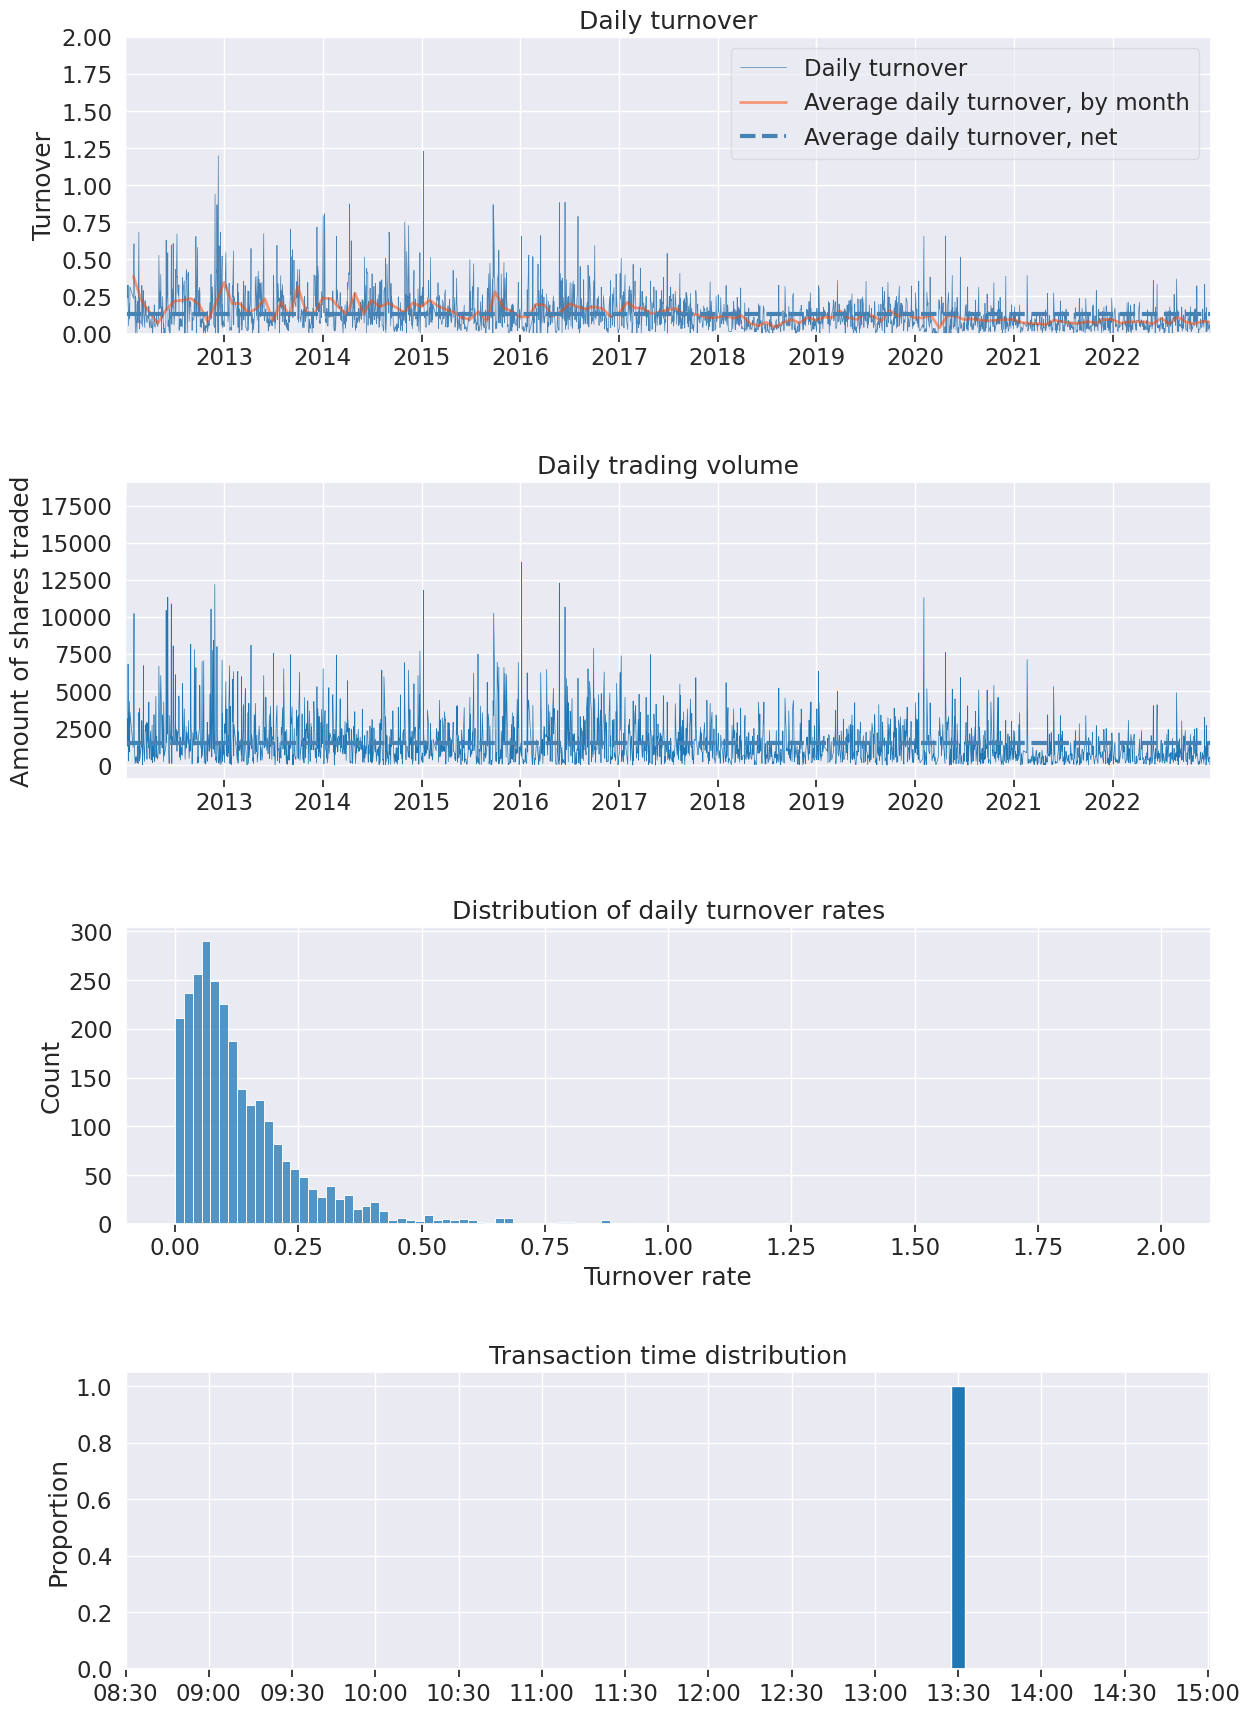

In [10]:
# 從 Zipline 結果中提取報酬、部位和交易資訊
bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# 取得基準指數報酬
benchmark_rets = results.benchmark_return

# 產生完整的績效分析報告
pf.create_full_tear_sheet(
    bt_returns,
    positions=bt_positions,
    transactions=bt_transactions,
    benchmark_rets=benchmark_rets,
    round_trips=False
)

In [39]:
# 僅顯示關鍵績效指標表格
pf.show_perf_stats(returns = bt_returns, positions=bt_positions, transactions=bt_transactions)

Start date,2012-01-02
End date,2022-12-30
Total months,128
,Backtest
Annual return,-2.636%
Cumulative returns,-24.903%
Annual volatility,11.743%
Sharpe ratio,-0.17
Calmar ratio,-0.06
Stability,0.65
Max drawdown,-45.969%


,Backtest
Annual return,-2.636%
Cumulative returns,-24.903%
Annual volatility,11.743%
Sharpe ratio,-0.16877
Calmar ratio,-0.057336
Stability,0.654737
Max drawdown,-45.969%
Omega ratio,0.961369
Sortino ratio,-0.239414
Skew,0.199771
